<a href="https://colab.research.google.com/github/haji8-de/AIFFEL_quest_rs/blob/main/Exploration/Ex02/make_person_image.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 기본 학습

In [27]:
! mkdir -p ~/work/human_segmentation/models
! mkdir -p ~/work/human_segmentation/images
! ln -s ~/data/* ~/work/human_segmentation/images

다음과 같은 후가공으로 '인물사진 모드'인 사진을 만들 겁니다.
배경이 있는 셀카를 촬영합니다. (배경과 사람의 거리가 약간 멀리 있으면 좋습니다.)
시맨틱 세그멘테이션(Semantic segmentation)으로 피사체(사람)와 배경을 분리합니다.
블러링(blurring) 기술로 배경을 흐리게 합니다.
피사체를 배경의 원래 위치에 합성합니다.

In [28]:
! pip install opencv-python pixellib # 다시 시작이 요구될 수 있습니다.

In [29]:
# cv2: OpenCV 라이브러리로, 실시간 컴퓨터 비전을 목적으로 한 프로그래밍 라이브러리
# numpy(NumPy): 행렬이나 대규모 다차원 배열을 쉽게 처리할 수 있도록 지원하는 라이브러리. 데이터 구조 외에도 수치 계산을 위해 효율적으로 구현된 기능을 제공
# torch: PyTorch. 딥러닝 및 텐서 연산을 위한 라이브러리. 인공지능 모델을 만들거나 불러와 추론하는 도구
# torchvision: 이미지 변환 및 전처리를 위한 torchvision의 transform 모듈
# deeplabv3_resnet101: 사전 학습된 DeepLabV3 모델. 이미지를 분류하도록 학습된 모델
# matplotlib: 파이썬 프로그래밍 언어 및 수학적 확장 NumPy 라이브러리를 활용한 플로팅 라이브러리로, 데이터 시각화 도구
# urllib는 웹에서 데이터를 다운로드할 때 사용합니다.
# pixellib는 시맨틱 세그멘테이션을 편하게 사용할 수 있는 라이브러리인데요. 아직 시맨틱 세그멘테이션 모델을 직접 만들기에는 어려우니 이번에는 준비된 모델을 사용만 해봅니다.

import cv2
import os
import numpy as np
import torch
import torchvision.transforms as T
from torchvision.models.segmentation import deeplabv3_resnet101
import matplotlib.pyplot as plt

print('슝=3')

슝=3


In [30]:
# 기본 제공 이미지입니다. 여러분만의 이미지로 바꿔보세요!
! wget https://d3s0tskafalll9.cloudfront.net/media/images/E-14-3.max-800x600_KwXP73b.png
! mv E-14-3.max-800x600_KwXP73b.png ~/work/human_segmentation/images/my_image.png

--2026-01-19 04:54:31--  https://d3s0tskafalll9.cloudfront.net/media/images/E-14-3.max-800x600_KwXP73b.png
Resolving d3s0tskafalll9.cloudfront.net (d3s0tskafalll9.cloudfront.net)... 3.165.75.32, 3.165.75.73, 3.165.75.75, ...
Connecting to d3s0tskafalll9.cloudfront.net (d3s0tskafalll9.cloudfront.net)|3.165.75.32|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 662087 (647K) [image/png]
Saving to: ‘E-14-3.max-800x600_KwXP73b.png’

E-14-3.max-800x600_ 100%[===================>] 646.57K  --.-KB/s    in 0.007s  

2026-01-19 04:54:31 (97.0 MB/s) - ‘E-14-3.max-800x600_KwXP73b.png’ saved [662087/662087]



이미지 크기: (450, 800, 3)


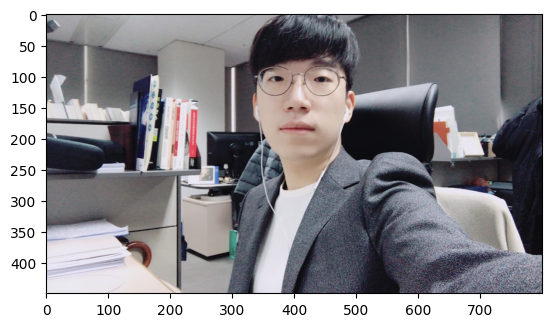

In [31]:
# 준비한 이미지 파일의 경로를 이용하여, 이미지 파일을 읽음
# cv2.imread(경로): 경로에 해당하는 이미지 파일을 읽어서 변수에 저장

home_dir = os.getenv('HOME')
img_path = os.path.join(home_dir, "work/human_segmentation/images/my_image.png")
img_orig = cv2.imread(img_path)

print(f"이미지 크기: {img_orig.shape}")

# cv2.cvtColor(입력 이미지, 색상 변환 코드): 입력 이미지의 색상 채널을 변경
# cv2.COLOR_BGR2RGB: 이미지 색상 채널을 변경 (BGR 형식을 RGB 형식으로 변경)
# plt.imshow(): 저장된 데이터를 이미지의 형식으로 표시, 입력은 RGB(A) 데이터 혹은 2D 스칼라 데이터
# https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.imshow.html
# plt.show(): 현재 열려있는 모든 figure를 표시 (여기서 figure는 이미지, 그래프 등)
# https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.show.html
plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))
plt.show()

### 3. 세그멘테이션으로 사람 분리하기

시맨틱 세그멘테이션은 '사람'이라는 추상적인 정보를 이미지에서 추출해 내는 방법입니다. 그래서 사람이 누구인지 관계없이 같은 라벨로 표현이 됩니다.
더 나아가서 인스턴스 세그멘테이션은 사람 개개인별로 다른 라벨을 가지게 합니다. 여러 사람이 한 이미지에 등장할 때 각 객체를 분할해서 인식하자는 것이 목표입니다.

In [32]:
model = deeplabv3_resnet101(pretrained=True).eval()



/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet101_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [33]:
transform = T.Compose([
    T.ToPILImage(),
    T.Resize((520, 520)),  # 모델 입력 크기 (고정)
    T.ToTensor(),
])


In [34]:
input_tensor = transform(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB)).unsqueeze(0)

In [35]:
%%time
with torch.no_grad():
    output = model(input_tensor)["out"][0]
    output_predictions = output.argmax(0).byte().cpu().numpy()

# 원본 크기로 Resize
output_predictions_resized = cv2.resize(output_predictions, (img_orig.shape[1], img_orig.shape[0]), interpolation=cv2.INTER_NEAREST)

CPU times: user 11.2 s, sys: 23.6 ms, total: 11.2 s
Wall time: 15.6 s


In [36]:
 #pascalvoc 데이터의 라벨종류
LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]
len(LABEL_NAMES)

21

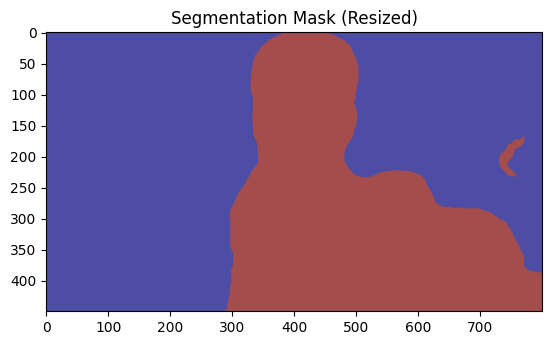

In [37]:
plt.imshow(output_predictions_resized, cmap="jet", alpha=0.7)
plt.title("Segmentation Mask (Resized)")
plt.show()

In [38]:
unique_classes = np.unique(output_predictions_resized)
unique_classes

array([ 0, 15], dtype=uint8)

In [39]:
for class_id in unique_classes:
    print(LABEL_NAMES[class_id])


background
person


In [40]:
# 아래 코드를 이해하지 않아도 좋습니다
# PixelLib에서 그대로 가져온 코드입니다
# 주목해야 할 것은 생성 코드 결과물이예요!

#컬러맵 만들기
colormap = np.zeros((256, 3), dtype=int)
ind = np.arange(256, dtype=int)

for shift in reversed(range(8)):
    for channel in range(3):
        colormap[:, channel] |= ((ind >> channel) & 1) << shift
    ind >>= 3

colormap[:20]  # 생성한 20개의 컬러맵 출력

array([[  0,   0,   0],
       [128,   0,   0],
       [  0, 128,   0],
       [128, 128,   0],
       [  0,   0, 128],
       [128,   0, 128],
       [  0, 128, 128],
       [128, 128, 128],
       [ 64,   0,   0],
       [192,   0,   0],
       [ 64, 128,   0],
       [192, 128,   0],
       [ 64,   0, 128],
       [192,   0, 128],
       [ 64, 128, 128],
       [192, 128, 128],
       [  0,  64,   0],
       [128,  64,   0],
       [  0, 192,   0],
       [128, 192,   0]])

In [41]:
colormap[15] #컬러맵 15에 해당하는 배열 출력 (pacalvoc에 LABEL_NAMES 15번째인 사람)

array([192, 128, 128])

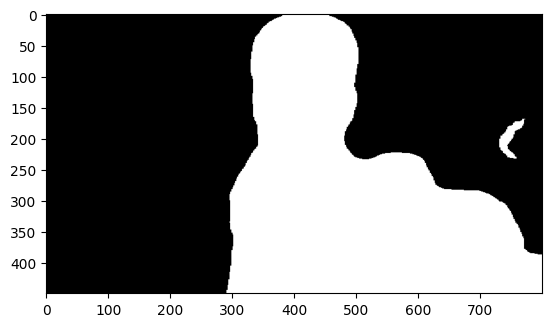

In [42]:
# output의 픽셀 별로 예측된 class가 사람이라면 1(True), 다르다면 0(False)이 됩니다
# 1과 0에 각각 255를 곱하였으므로 사람으로 예측된 픽셀은 255, 그렇지 않은 픽셀은 0
# cmap 값을 변경하면 다른 색상으로 확인이 가능함
seg_map = (output_predictions_resized == 15)  # 클래스 ID 15 (사람)
img_mask = seg_map.astype(np.uint8) * 255  # 255 값으로 변환
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)

plt.imshow(img_mask, cmap='gray')  # 흑백으로 표시
plt.show()

In [43]:
###
# 어떤가요? 3채널 가졌던 원본과는 다르게 채널 정보가 사라졌습니다.
# 이제 아래처럼 물체가 있는 위치는 1(True), 그 외에는 0(False)인 배열이 되었습니다.
# [
# [ 0 1 1 0 0 0 1 1 0 ],
# [ 1 1 1 1 0 1 1 1 1 ],
# [ 0 1 1 1 1 1 1 1 0 ],
# [ 0 0 1 1 1 1 1 0 0 ],
# [ 0 0 0 1 1 1 0 0 0 ]
# ]

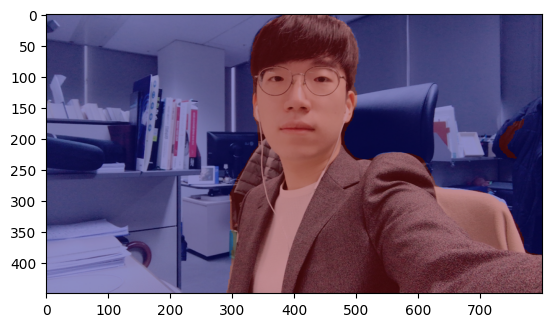

In [44]:
# 원본 이미지와 마스트를 적당히 합쳐봅니다
# 0.6과 0.4는 두 이미지를 섞는 비율입니다.

img_show = cv2.addWeighted(img_orig, 0.6, color_mask, 0.4, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

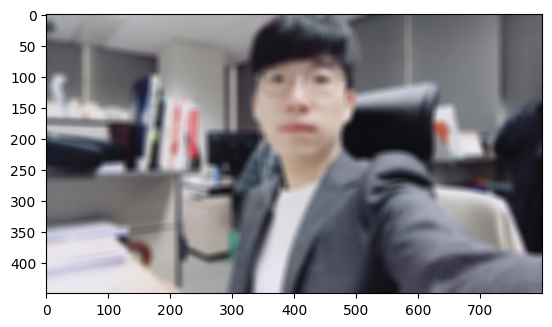

In [45]:
# (13,13)은 blurring kernel size를 뜻합니다
# 다양하게 바꿔보세요
img_orig_blur = cv2.blur(img_orig, (13, 13))

# plt.imshow(): 저장된 데이터를 이미지의 형식으로 표시한다.
# cv2.cvtColor(입력 이미지, 색상 변환 코드): 입력 이미지의 색상 채널을 변경
# cv2.COLOR_BGR2RGB: 원본이 BGR 순서로 픽셀을 읽다보니
# 이미지 색상 채널을 변경해야함 (BGR 형식을 RGB 형식으로 변경)
plt.imshow(cv2.cvtColor(img_orig_blur, cv2.COLOR_BGR2RGB))
plt.show()

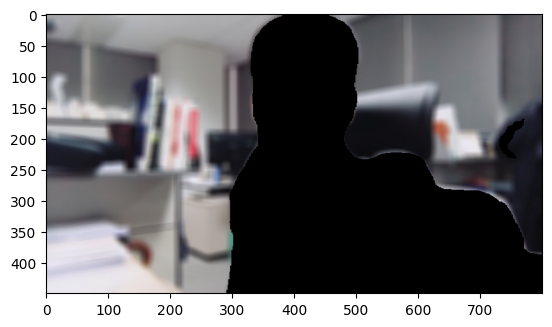

In [46]:
# cv2.cvtColor(입력 이미지, 색상 변환 코드): 입력 이미지의 색상 채널을 변경
# cv2.COLOR_BGR2RGB: 원본이 BGR 순서로 픽셀을 읽다보니
# 이미지 색상 채널을 변경해야함 (BGR 형식을 RGB 형식으로 변경)
img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)

# cv2.bitwise_not(): 이미지가 반전됩니다. 배경이 0 사람이 255 였으나
# 연산을 하고 나면 배경은 255 사람은 0입니다.
img_bg_mask = cv2.bitwise_not(img_mask_color)

# cv2.bitwise_and()을 사용하면 배경만 있는 영상을 얻을 수 있습니다.
# 0과 어떤 수를 bitwise_and 연산을 해도 0이 되기 때문에
# 사람이 0인 경우에는 사람이 있던 모든 픽셀이 0이 됩니다. 결국 사람이 사라지고 배경만 남아요!
img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

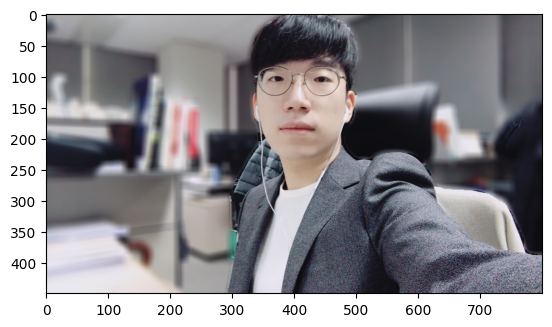

In [47]:
# np.where(조건, 참일때, 거짓일때)
# 세그멘테이션 마스크가 255인 부분만 원본 이미지 값을 가지고 오고
# 아닌 영역은 블러된 이미지 값을 사용합니다.
img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)
# plt.imshow(): 저장된 데이터를 이미지의 형식으로 표시한다.
# cv2.cvtColor(입력 이미지, 색상 변환 코드): 입력 이미지의 색상 채널을 변경
# cv2.COLOR_BGR2RGB: 원본이 BGR 순서로 픽셀을 읽다보니
# 이미지 색상 채널을 변경해야함 (BGR 형식을 RGB 형식으로 변경)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

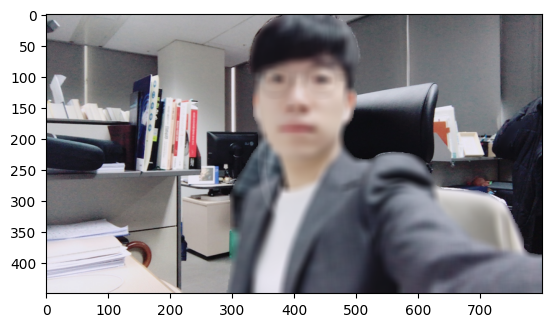

In [48]:
# Q. 이번에는 사람 부분을 블러로, 배경 부분을 원본으로 출력해볼까요?
# 힌트 : img_mask_color 옵션을 적절히 조정해주고, img_orig, img_orig_blur 를 활용하세요.
img_concat = np.where(img_mask_color == 255, img_orig_blur, img_orig)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

# 인물모드 문제점 찾기

In [49]:
!pip install opencv-python pixellib

In [50]:
import cv2
import numpy as np
import torch
import torchvision.transforms as T
from torchvision.models.segmentation import deeplabv3_resnet101
import matplotlib.pyplot as plt

print(cv2.__version__)

4.11.0


원본 고양이 이미지 크기: (187, 270, 3)
배경(사막) 이미지 크기: (168, 300, 3)


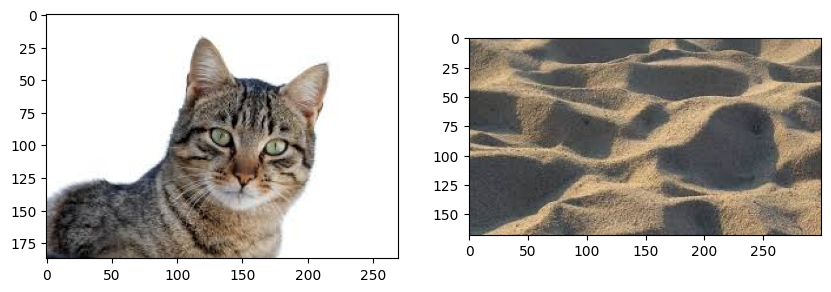

In [51]:

home_dir = os.getenv('HOME')
cat_img_path = os.path.join(home_dir, "work/human_segmentation/images/cat_01.jpeg")
sand_img_path = os.path.join(home_dir, "work/human_segmentation/images/sand_01.jpeg")
   # 고양이 이미지를 준비해주세요   # 사막 배경 이미지를 준비해주세요

cat_img = cv2.imread(cat_img_path)
sand_img = cv2.imread(sand_img_path)

cat_img = cv2.cvtColor(cat_img, cv2.COLOR_BGR2RGB)
sand_img = cv2.cvtColor(sand_img, cv2.COLOR_BGR2RGB)

print(f"원본 고양이 이미지 크기: {cat_img.shape}")
print(f"배경(사막) 이미지 크기: {sand_img.shape}")

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(cat_img)

plt.subplot(1, 2, 2)
plt.imshow(sand_img)

plt.show()

In [52]:
model = deeplabv3_resnet101(pretrained=True).eval()

transform = T.Compose([
    T.ToPILImage(),
    T.Resize((520, 520)),  # 모델 입력 크기
    T.ToTensor(),
])

input_tensor = transform(cat_img).unsqueeze(0)

with torch.no_grad():
    output = model(input_tensor)["out"][0]
    output_predictions = output.argmax(0).byte().cpu().numpy()

print(f"추론 마스크 크기 (Before Resize): {output_predictions.shape}")

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet101_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


추론 마스크 크기 (Before Resize): (520, 520)


In [53]:
# 마스크를 원본 크기로 Resize
output_predictions_resized = cv2.resize(output_predictions, (cat_img.shape[1], cat_img.shape[0]), interpolation=cv2.INTER_NEAREST)

print(f"추론 마스크 크기 (After Resize): {output_predictions_resized.shape}")

추론 마스크 크기 (After Resize): (187, 270)


In [54]:
unique_classes = np.unique(output_predictions_resized)
print(f"예측된 클래스 ID: {unique_classes}")

예측된 클래스 ID: [0 8]


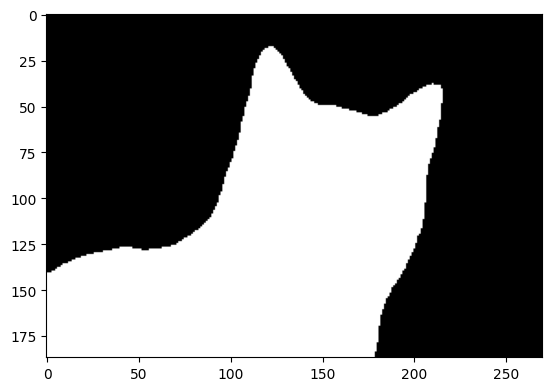

In [55]:
target_class_id = unique_classes[-1]

seg_map = (output_predictions_resized == target_class_id)
img_mask = seg_map.astype(np.uint8) * 255

plt.imshow(img_mask, cmap='gray')
plt.show()

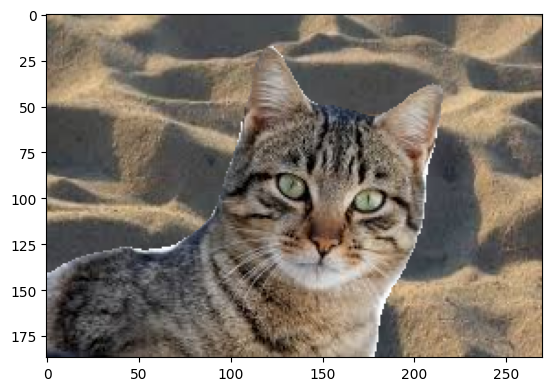

In [56]:
# 배경을 고양이 이미지 크기에 맞춤
sand_img_resized = cv2.resize(sand_img, (cat_img.shape[1], cat_img.shape[0]))

# 고양이 부분만 남기고 배경 적용
img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)  # 3채널 변환
result_img = np.where(img_mask_color == 255, cat_img, sand_img_resized)  # 마스크 기반 합성

plt.imshow(result_img)
plt.show()